In [3]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict

import dvu
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import clean
import viz

plt.style.use('default')
dvu.set_style()

df = pd.read_pickle('../data/cdis_with_schemas.pkl')

# remove formulaic outputs
df = df[~df['purpose_en'].apply(lambda x: 'Formula' in x)]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# x = d[d.url == 'cha2ds2-vasc-score-atrial-fibrillation-stroke-risk'].iloc[0]
# x = df.iloc[0]
# schema = x['input_schema']
# schema
# for s in schema:
#     options = s['options']
#     print(s['name'], clean.clean_feature_name(s['label_en']), [opt['value'] for opt in options])

**Get feature names as list**

In [5]:
def get_feature_names_with_vals_list(schema):
    if isinstance(schema, list):
        feature_names_with_vals = []
        tot_points = 0
        for s in schema:
            feature_name = clean.clean_feature_name(s['label_en']) if 'label_en' in s else 'unknown'
            if not s == 'unknown':
                feature_name = clean.rename_feature_name(feature_name)
                if 'options' in s:
                    points = [opt['value'] for opt in s['options']]
                    point_range = max(points) - min(points)
                    tot_points += max(points)
                else: # example: age text box
                    # print('feature_name', feature_name, 'has no options')
                    # point_range = None
                    return [] # skip anything that isn't all options for now
                feature_names_with_vals.append((feature_name, point_range))

        # normalize by tot_points
        return [(feature_name, point_range / tot_points)
                for (feature_name, point_range) in feature_names_with_vals]
    else:
        return []


df['feature_names_with_vals'] = df['input_schema'].apply(get_feature_names_with_vals_list)

# only keep scoring-only CDIs
d = df['feature_names_with_vals'][df['feature_names_with_vals'].apply(len) > 0]
print('only keeping', d.shape[0], 'CDIs out of', df.shape[0])

only keeping 288 CDIs out of 554


In [6]:
score_tuples = sorted(sum(d, []), key=lambda x: x[0])
ks = sorted(set([score_tuple[0] for score_tuple in score_tuples]))
score_dict = defaultdict(list)
for key, score in score_tuples:
    score_dict[key].append(score)

In [7]:
score_dict_filt = [
    (k, v)
    for (k, v) in score_dict.items()
    if len(v) >= 5
]
scores_list = sorted(score_dict_filt, key=lambda x: len(x[1]), reverse=True)
feat_name_vec = sum([[k] * len(v) for (k, v) in scores_list], [])
score_vec = sum([v for (k, v) in scores_list], [])
df_box = pd.DataFrame.from_dict({'feat_name': feat_name_vec, 'score': score_vec})

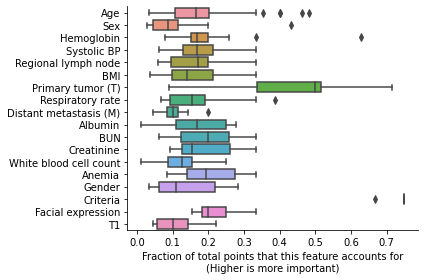

In [8]:
sns.boxplot(x='score', y='feat_name', data=df_box)
plt.ylabel('')
plt.xlabel('Fraction of total points that this feature accounts for\n(Higher is more important)')
viz.savefig('scoring_cdi_boxplot')

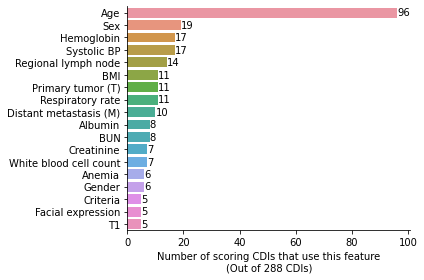

In [9]:
ax = sns.barplot(y=[k for (k, v) in scores_list],
            x=[len(v) for (k, v) in scores_list],
            )
ax.bar_label(ax.containers[0])
plt.xlabel(f'Number of scoring CDIs that use this feature\n(Out of {d.shape[0]} CDIs)')
plt.tight_layout()
viz.savefig('scoring_cdi_counts')